In [1]:
##### This code is from Updated Testing Reddit - No Con- bias (Fictitious Play)-01092022
##### This code replace the big real datanetwork with small sythetic network 
import scipy
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
import time
import random
from scipy.stats import beta
import pandas as pd
import copy
%matplotlib inline
%run Helpers.ipynb
#%run pure_strategy_selection.ipynb  #include simple selection algorithm
import scipy.io
import collections
import sys


## Mathmatic Functions

In [2]:
# centers the opinion vector around 0\n",
def mean_center(op, n):
    ones = np.ones((n, 1))
    x = op - (np.dot(np.transpose(op),ones)/n) * ones
    return x
    
# compute number of edges, m\n
def num_edges(L, n):
    m = 0
    for i in range(n):
        for j in range(n):
            if i > j and L[i,j] < 0:
                m += 1            
    return m

# maximizing polarization only: \\bar{z}^T \\bar{z}   
def obj_polarization(A, L, op, n):
    op_mean = mean_center(op, n)
    z_mean = np.dot(A, op_mean) 
    return np.dot(np.transpose(z_mean), z_mean)[0,0] 

def obj_polarization_1(A, L, op, n):
    z = np.dot(A, op) 
    z_mean = mean_center(z, n)
    return np.dot(np.transpose(z_mean), z_mean)[0,0] 

# Calculate innate polarization
def obj_innate_polarization(s, n):  
#     np.set_printoptions(precision=5)
    op_mean = mean_center(s, n)
    return np.dot(np.transpose(op_mean), op_mean)[0,0]

In [3]:
# Parameters for the network

np.set_printoptions(precision=3)
n = 20

## Creating Network
### 1. Make Random Network

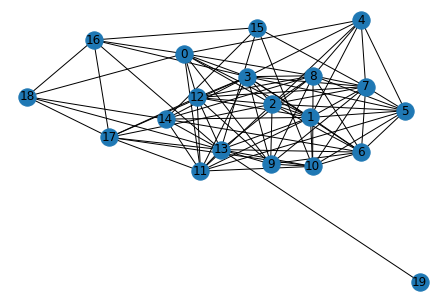

In [4]:
def make_innat_opinions(n): # Make opinion for agents only - no info source is involved
    
    # Make list of ind innate opinion to define info source opinion
    innat_s = np.random.uniform(low=0, high=1, size=int(n))   #individual's innate opinion 

    s = np.zeros((n, 1))
    
    idx1 = 0
    for i in range(len(s)):
        s[i] = innat_s[idx1]  #set innate opinion for ind.
        idx1 += 1
  
    return s

def make_random_network(n):
    # Create empty graph
    nxG = nx.Graph()
    # Add nodes to graph
    nxG.add_nodes_from(range(n))
    # Add edges based on node index
    for i in range(n):
        for j in range(i):
            p = (n-i)/(n-j) # Probability of edge existing
            if np.random.random() < p:
                nxG.add_edge(i, j)

    # Draw graph
    nx.draw(nxG, with_labels=True)
    plt.show()
    G = nx.adjacency_matrix(nxG).todense()
    
    return G

s = make_innat_opinions(n)
G = make_random_network(n)




20


<Figure size 1440x1440 with 0 Axes>

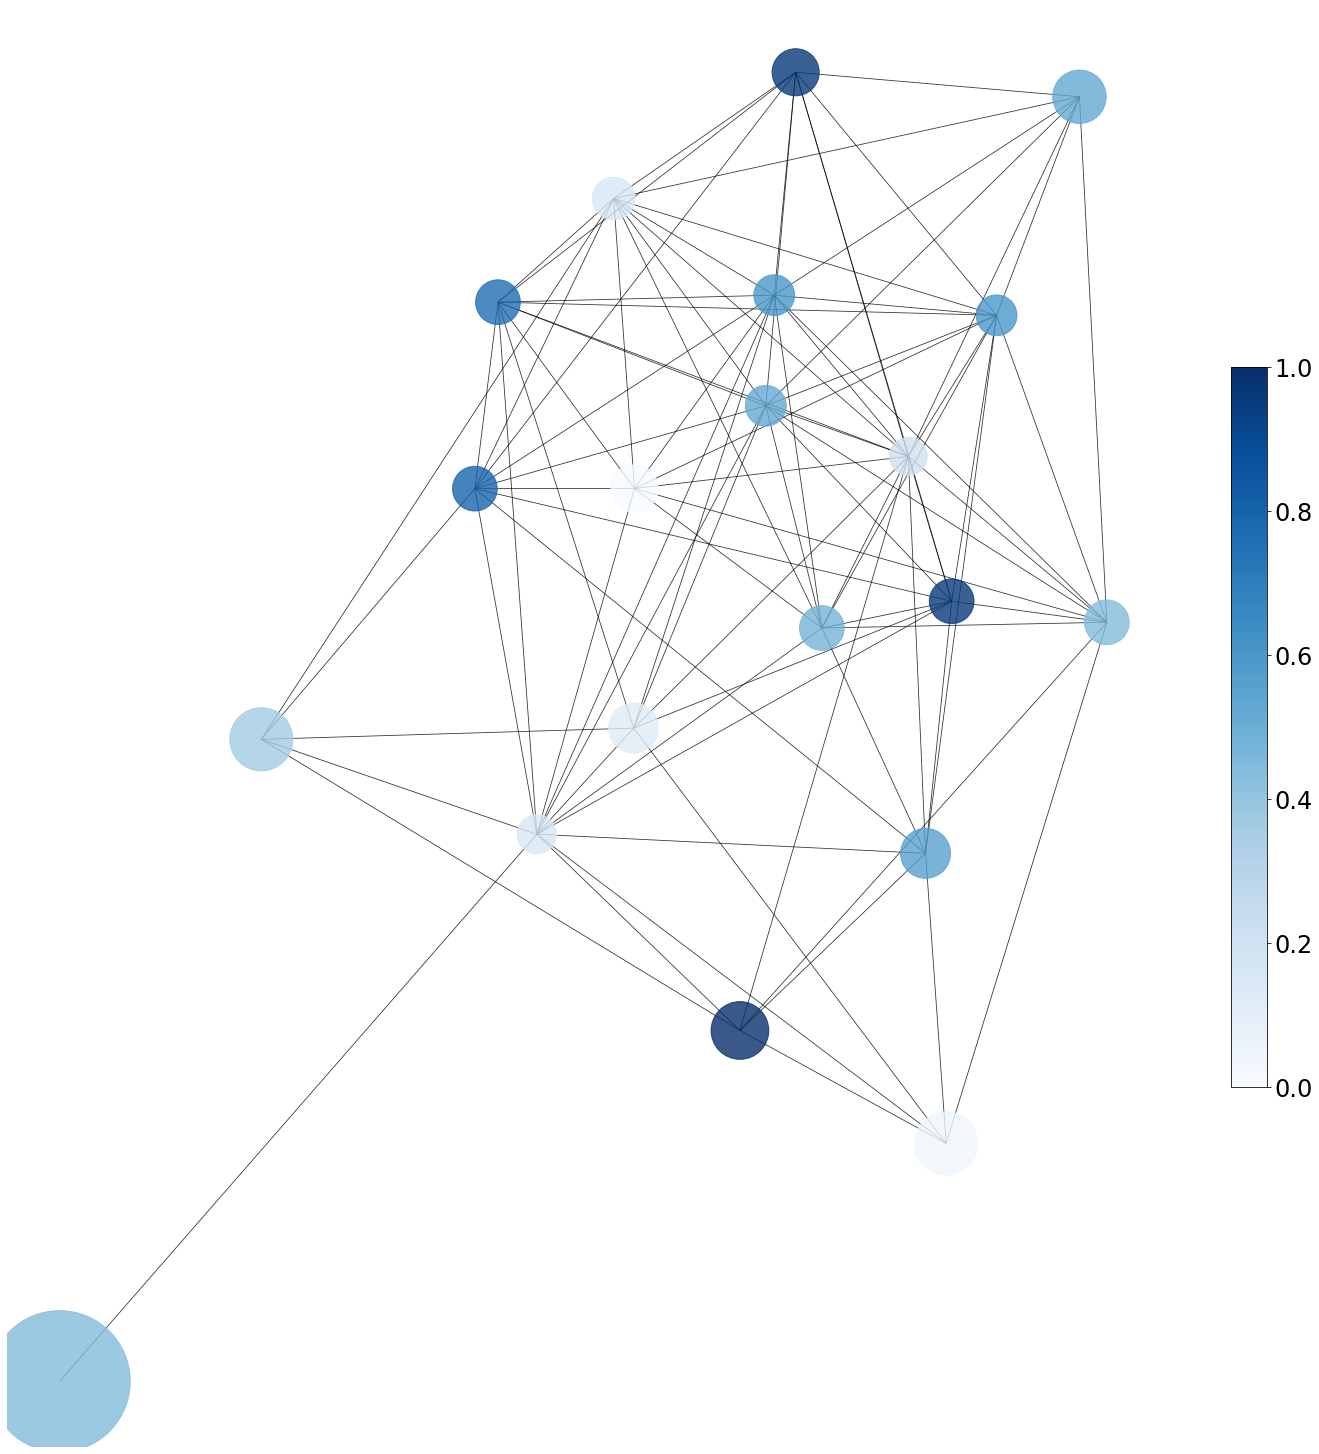

In [7]:
# what the twitter graph looks like 
s_use = s.flatten()   # Convert array to a list for later operation
s_use = s_use.tolist()
new_s = [i * 30 for i in s_use]
df = pd.DataFrame(new_s, columns=['Opinion']) #create a datafram with index at column 1, opinion at column 2

nxG = nx.from_numpy_matrix(G)   
# nxG = nx.relabel_nodes(nxG, mapping)      
plt.figure(figsize=(20, 20))


def node_edge(G, n):
    edges =[]
    for v in range(n):
        a = np.array(np.nonzero(G[v])[0])
        edge = len(a)
#         print(edge)
        edges.append(edge)
        
    return edges

node_edges = node_edge(G, n)
# print(node_edges)

node_sizes =[]
for i in node_edges:
    node_size = 1/i*20000
    node_sizes.append(node_size)

min_equi = [202,351,490]
max_equi = [199, 529, 37]
# Create node color
color_map = []
for node in nxG:
    if node in min_equi:
        color_map.append('orange')
    elif node in max_equi:
        color_map.append('red')
    else:
        color_map.append('grey')
# print(node_sizes)

######################### Calculate Key Values & Visualization #######################################3
L = scipy.sparse.csgraph.laplacian(G, normed=False)  # Return the Laplacian matrix
A = np.linalg.inv(np.identity(n) + L)  # A = (I + L)^(-1)\n  Stanford paper theory
m = num_edges(L, n)                    # call the function to calculate the number of edges
columnsum_ij = np.sum(A, axis=0)
#print(columnsum_ij)
print(n)
# what the twitter graph looks like 
nxG = nx.from_numpy_matrix(G)          
plt.figure(figsize=(20, 20))

# Fix seed - fix network shape
my_pos = nx.spring_layout(nxG, seed = 2)
nx.draw(nxG, pos= my_pos, with_labels= False, node_color=df['Opinion'].astype(int),cmap=plt.cm.Blues, node_size= node_sizes, edge_color='black', width=0.8, font_color='black',font_size=26, font_weight='bold', alpha=0.8)
#nx.draw(nxG, pos = my_pos, with_labels=False, node_color=color_map, node_size= node_sizes, edge_color='grey', width=0.5, font_color='white',font_size=9, font_weight='bold')
sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin = 0, vmax=1))
cbar = plt.colorbar(sm, shrink = 0.5)
tick_font_size = 24
cbar.ax.tick_params(labelsize=tick_font_size)
plt.show()

# if we want to customize the color bar range to min/max s
# vmin = min(s)
# vmax = max(s)
# sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin = vmin, vmax=vmax))
# sm._A = []
# plt.colorbar(sm,shrink=0.5)
# plt.show()

### 4. Equilibrium & Polarization  - based on derivation
$$P(z) = z ^T * z $$


In [8]:

## s =  make_innat_opinions(n, c1)
# print('Innate Opinion')
# print(s)
# print('Equilibrium Opinion')
# print(np.dot(A, s))

op = s
y = mean_center(s,n)
# print(y)
innat_pol = np.dot(np.transpose(y), y)[0,0] 
print('Innate_polarization:')
print(innat_pol)

# Test equilibrium polarization
equ_pol = obj_polarization(A, L, s, n)
print('Equi_polarization:')
print(equ_pol)

di = equ_pol-innat_pol
print("Difference:")
print(di)

Innate_polarization:
1.2454482890069372
Equi_polarization:
0.016937538864741707
Difference:
-1.2285107501421955


### Testing players' behavior

In [9]:
def MaxMin_play(s,n):    # maxmizer first-time play, greedy algorithm
    print('Maximizer Play')
   
    (v1, max_opinion, max_pol, min_action) = choose_max_vertex(s, n) # The best choice among all opinions and vertexs, function is in "pure_strategy_selection.ipynb"
    (v2, min_opinion) = min_action
    if v1 == None:   # if maximizer cannot find one
        print('Maximizer fail')

    else:
        print("                                ")
        print("Maximizer finds its target agent:")
#         print('v1', 'changed_opinion', 'innate_obj', 'obj')
#         print(max_champion)

        #Store innate_op of the max_selected vertex
        old_opinion_max = s[v1, 0]
        old_opinion_min = s[v2, 0]
        ##### change the agent's opinion with best action(agent v1, max_op)

        ## check if agent's opinionis is changed or not
        print("Max Action:    "+"Agent" + str(v1) +" 's opinion " + str(old_opinion_max) + " changed to "+ str(max_opinion))
        print("Min Action:    "+"Agent" + str(v2) +" 's opinion " + str(old_opinion_min) + " changed to "+ str(min_opinion))
        print("Network reaches equilibrium Polarization: " + str(max_pol))


    return(v1, max_opinion, max_pol)


# determines if value of opinion at v should be set to 0 or 1 to maximize equilibrium polarization 
def get_max_opinion(s, n, v1):
    
    por_arr = np.zeros(2)  # create a two_element array to store polarization value of each option
    max_opi_option = [0, 1.0]   # Maximizer has two options to change agent v1's opinion
    min_actions = []
    # objective if set opinion to 0, 1.0
    j = 0
    for max_opinion in max_opi_option:
        (v2,min_opinion, min_pol) = maxmin_polar(s,v1,max_opinion)
        por_arr[j] = min_pol
        j = j + 1   # index increase 1, put the polarization in array
        min_actions.append((v2,min_opinion))

    maxmize_op = np.argmax(por_arr)  # the index of maximum polarization = max_opinion --[0,1]
    max_por = np.max(por_arr)        # find the maximum polarization in the record
    min_action = min_actions[np.argmax(por_arr)] 
    
    return (maxmize_op, max_por, min_action)

# determine which agent maximizer should select to maximizer the equilibrium polarization
def choose_max_vertex(s, n):
   # max_por = obj_polarization(A, L, op, n)  # use "innate"(after min action) polarization as a comparable standard to find max_por
    max_por = 0
    C1 = list(range(n))    # for all agent 
    for v1 in C1:         
            print('Maximizer start from agent'+str(v1))
            (max_opinion, por, min_action) = get_max_opinion(s, n, v1)
 
            if por > max_por: # if the polarization of most recent action > maximum polarization of previous actions
                max_por = por
                champion = (v1, max_opinion,max_por, min_action)   # save the this action as champion    

    return (champion)


def maxmin_polar(s, v1, max_opinion):
    op = copy.copy(s)
    op[v1] = max_opinion  
    (v2,min_opinion, min_pol) = minimizer_play(op,n,v1)
    
    return (v2,min_opinion, min_pol)
    
 ##### minimizer first-time play, greedy algorithm
def minimizer_play(op,n,max_touched): 
    
    op1 = copy.copy(op)
    min_champion = choose_min_vertex(op1, n, max_touched) 
    (v2, min_opinion, min_pol) = min_champion
    
    if v2 == None:
        print('Minimizer fail')

    return (v2,min_opinion, min_pol)   

def derivate_s(op,n,v2):
               #op - opinion array that updated by maximizer
    c = [1/n] * n
#     print(c)
    sum_term = 0
    j = 0

    sum_term = np.dot(np.dot((A-c),(A[v2]-c)),op)  # sum up all terms
    
    term_out = op[v2]*np.dot((A[v2]-c),(A[v2]-c)) # exclude the term that j = v2
    sum_s = sum_term - term_out    # numerator
    
    s_star = -sum_s/np.dot((A[v2]-c),(A[v2]-c))
    s_star = s_star[0] #take value out of array
#     print(str(v2)+'s_star:'+str(s_star))
    #min_opinion =min(max(0,s_star),1)
    bound = (0,1)
    por_arr = []  # create a two_element array to store polarization value of each option
    
    if s_star<0 or s_star>1:
        for min_opinion in bound:
#             print('min_opinion:', min_opinion)
            #change max_opinion array and calculate the polarization
            op1 = copy.copy(op)
            op1[v2] = min_opinion   #after max action, update min action on opinion array
#             print('op1:', op1)
            min_por = obj_polarization(A, L, op1, n)
            por_arr.append(min_por)
#         print("por_arr:", por_arr)
        minmize_op = np.argmin(por_arr)  # the index of maximum polarization = max_opinion --[0,1]
        min_por = np.min(por_arr)        # find the maximum polarization in the record    
    else:
        minmize_op = s_star
        op1 = copy.copy(op)
        op1[v2] = minmize_op   #after max action, update min action on opinion array
#         print('op1:', op1)
        min_por = obj_polarization(A, L, op1, n)
        
    return (minmize_op, min_por)
 
    
    
    
    
# Minimizer search: Go through each agent 

def choose_min_vertex(op, n, max_touched):
    # current opinion array that changed by maximizer, "innate" opinion that min start with

    champion = (None, None, 0, None)  # assume the best action is champion
    min_por = 10000
    all = list(range(n))    # for all agent 
    C1 = [x for x in all if x != max_touched]  # for the vertice that Maximizer has not touched
    
    for v2 in C1:   
        if v2 == max_touched:
            O_P = obj_innate_polarization(s, n)
            champion = (v2, s[v2], O_P)
        else:
            #print('Min start with agent '+ str(v2) )
            (changed_opinion, por) = derivate_s(op,n,v2)   # find the best new_op option           

            if por < min_por:  # if the recent polarization is smaller than the minimum polarization in the history
                min_por = por
                                     # update the recent option as champion
                champion = (v2, changed_opinion, min_por)  
#     print("Min champion:", champion)
    return (champion)  # find the best minimizer's action after going through every new_op option of every agent





In [10]:
MaxMin_play(s,n)

Maximizer Play
Maximizer start from agent0
Maximizer start from agent1
Maximizer start from agent2
Maximizer start from agent3
Maximizer start from agent4
Maximizer start from agent5
Maximizer start from agent6
Maximizer start from agent7
Maximizer start from agent8
Maximizer start from agent9
Maximizer start from agent10
Maximizer start from agent11
Maximizer start from agent12
Maximizer start from agent13
Maximizer start from agent14
Maximizer start from agent15
Maximizer start from agent16
Maximizer start from agent17
Maximizer start from agent18
Maximizer start from agent19
                                
Maximizer finds its target agent:
Max Action:    Agent19 's opinion 0.3718937301683093 changed to 1
Min Action:    Agent14 's opinion 0.12607584324744592 changed to 1
Network reaches equilibrium Polarization: 0.07732262067297363


(19, 1, 0.07732262067297363)

# 5. Innate Op and Game

In [26]:
op = s
y = mean_center(s,n)
# print(y)
innat_pol = np.dot(np.transpose(y), y)[0,0] 
print('Innate_polarization:')
print(innat_pol)

# Test equilibrium polarization
equ_pol = obj_polarization(A, L, op, n)
print('Equi_polarization:')
print(equ_pol)

di = equ_pol-innat_pol
print("Difference:")
print(di)



Innate_polarization:
1.1743186020487546
Equi_polarization:
0.15967526924290512
Difference:
-1.0146433328058495


In [27]:
### Save simulation result to TXT file

with open('Result'+str(Network)+'.'+str(Experiment)+'.txt', "a") as f:
#     print(Experiment_note, file=f)
    print('Initial Condition -(agent, opinion, pol)', file=f)
    print('Innate op'+str(s),file=f)
    print('Adjacency matrix'+ str(G), file=f)
  

NameError: name 'Network' is not defined